In [3]:
import numpy as np
import pandas as pd 
df = pd.read_csv("/kaggle/input/fetch-new/data_daily.csv")
df.head()

import holidays
from datetime import datetime, date 

df['Datetime'] = pd.to_datetime(pd.date_range(start='2021-01-01', end='2021-12-31'))
df = df.set_index(['Datetime'])

df['month'] = df['# Date'].apply(lambda x : int(x.split('-')[1]))
df['day'] = df['# Date'].apply(lambda x : int(x.split('-')[2]))

month_seasons = {1:0, 2:0,3:1,4:1,5:1,6:2,7:2,8:2,9:3,10:3,11:3,12:0}
df['season'] = df['month'].apply(lambda x : month_seasons[x])


df['Date'] = pd.to_datetime(df['# Date'], format = '%Y/%m/%d')
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['dayofweek'] = pd.DatetimeIndex(df['Date']).dayofweek
df['Sunday'] = df['dayofweek'].apply(lambda x : 1 if x==6 else 0)
df['Saturday'] = df['dayofweek'].apply(lambda x : 1 if x==5 else 0)

# Assuming the data is for US
df['hols'] = pd.Series(df.index).apply(lambda x: holidays.CountryHoliday('US',prov='NSW').get(x)).values
df['hols'] = df['hols'].apply(lambda x: 1 if x != None else 0)

del df['# Date']
# del df['Date']

df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


,Receipt_Count,month,day,season,Date,day_of_year,week_of_year,quarter,dayofweek,Sunday,Saturday,hols
Datetime,,,,,,,,,,,,
2021-01-01,7564766,1,1,0,2021-01-01,1,53,1,4,0,0,1
2021-01-02,7455524,1,2,0,2021-01-02,2,53,1,5,0,1,0
2021-01-03,7095414,1,3,0,2021-01-03,3,53,1,6,1,0,0
2021-01-04,7666163,1,4,0,2021-01-04,4,1,1,0,0,0,0
2021-01-05,7771289,1,5,0,2021-01-05,5,1,1,1,0,0,0


In [4]:
df.isna().sum() 

Receipt_Count    0
month            0
day              0
season           0
Date             0
day_of_year      0
week_of_year     0
quarter          0
dayofweek        0
Sunday           0
Saturday         0
hols             0
dtype: int64

### In EDA we already determined that the dataset is non-stationary time series. 
Hence lets go with LSTM.

In [11]:
mean_ = np.mean(df['Receipt_Count'])
std_ = np.std(df['Receipt_Count'])
df['Receipt_Count'] = (df['Receipt_Count']-mean_)/std_

train = df.head(300)
test = df.tail(65)

y_train = train['Receipt_Count']
y_test = test['Receipt_Count']

x_train = np.expand_dims(train.loc[:, train.columns != 'Receipt_Count'], axis=2)
x_test  = np.expand_dims(test.loc[:, test.columns != 'Receipt_Count'], axis=2)

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(300, 11, 1) (300,) (65, 11, 1) (65,)


In [12]:
# from keras.models import Sequential
# from keras.layers import LSTM,Dense,Dropout
# from keras.models import load_model, Model

# # our defining sales model 
# sales_model = Sequential()
# sales_model.add(LSTM(units = 64, input_shape = (11,1)))
# # sales_model.add(LSTM(units = 64,activation='relu'))
# sales_model.add(Dropout(0.5))
# sales_model.add(Dense(1))

# sales_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
# sales_model.summary()

# sales_model.fit(x_train, y_train, batch_size = 100, epochs = 60)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


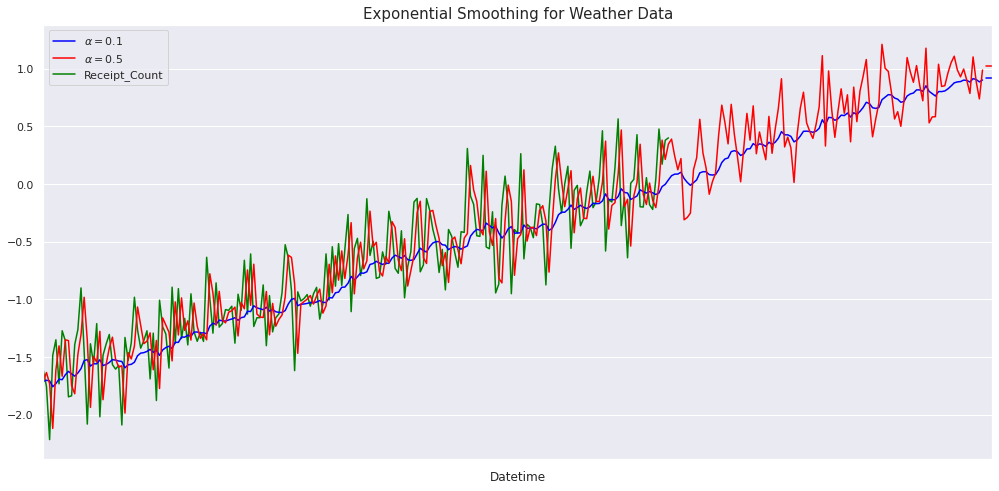

In [19]:
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
import pandas as pd

fit1 = ExponentialSmoothing(df["Receipt_Count"][0:300]).fit(smoothing_level=0.1, optimized=False)
fit2 = ExponentialSmoothing(df["Receipt_Count"][0:300]).fit(smoothing_level=0.8, optimized=False)
forecast1 = fit1.forecast(3).rename(r'$\alpha=0.1$')
forecast2 = fit2.forecast(3).rename(r'$\alpha=0.5$')
plt.figure(figsize=(17,8))

forecast1.plot(color='blue', legend=True)
forecast2.plot(color='red', legend=True)
df["Receipt_Count"][0:200].plot(marker='',color='green', legend=True)
fit1.fittedvalues.plot(color='blue')
fit2.fittedvalues.plot(color='red')
plt.title("Exponential Smoothing for Sales Data", fontsize=15)
plt.xticks([])

plt.show()

MSE error: 0.11008978940657184


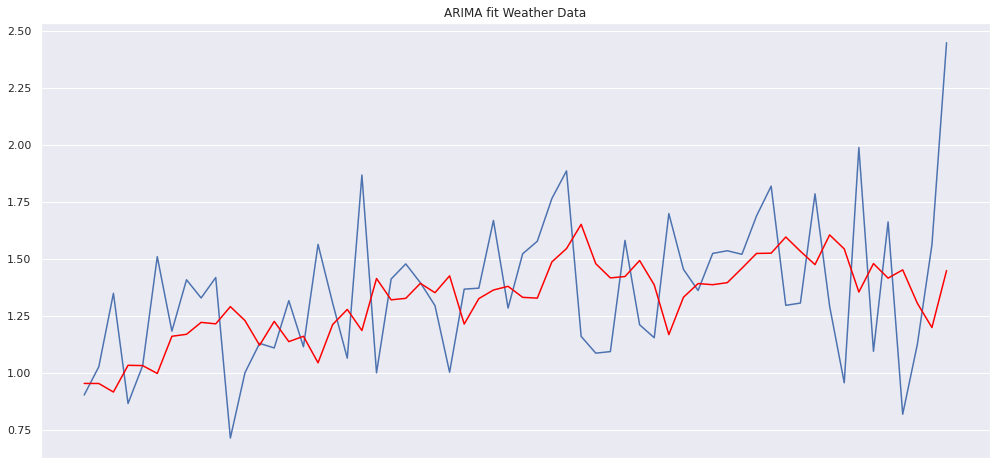

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd

X = df["Receipt_Count"].values

train_size = 300
test_size = 60

train, test = X[0:train_size], X[train_size:train_size+test_size]

history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

mse = mean_squared_error(test, predictions)
print(f"MSE error: {mse}")
plt.figure(figsize=(17,8))

plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA fit Weather Data")
plt.xticks([])
plt.show()
# MSE error: 3.105596078192541

# Main code

In [33]:
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i][1] - dataset[i - interval][1]
        diff.append(value)
    return numpy.array(diff)
 
# load dataset
series = read_csv('/kaggle/input/fetch-new/data_daily.csv', header=0)
# seasonal difference
X = series.values
days_in_year = 365
differenced = difference(X, 1)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()
# print summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  364
Model:                 ARIMA(7, 0, 1)   Log Likelihood               -4990.833
Date:                Sun, 05 Feb 2023   AIC                          10001.666
Time:                        03:02:30   BIC                          10040.637
Sample:                             0   HQIC                         10017.155
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7270.3870    246.215     29.529      0.000    6787.814    7752.960
ar.L1          0.0246      0.063      0.391      0.696      -0.099       0.148
ar.L2         -0.0200      0.065     -0.310      0.7

In [39]:
forecast = model_fit.forecast()[0]
forecast

-114326.70992725066

In [42]:
def inverse_difference(history, yhat, interval=1):
#     print(yhat, history)
    return yhat + history[-interval][1]

forecast = inverse_difference(X, forecast, 1)
forecast

10096860.290072748

In [49]:
start_index = len(differenced)
end_index = len(differenced)
forecast = model_fit.predict(start=start_index, end=end_index)

forecast

array([-114326.70992725])

In [58]:
forecast

array([14796.26839921, 21690.52945545, 27428.54028089, 16172.2135153 ,
       12026.25447125,  4743.68847436,  4491.9510632 ,  5141.291254  ,
        6807.91441383,  7429.79249369,  7748.55725082,  7576.13688203,
        7397.66437706,  7241.5305968 ,  7206.62479762,  7216.10689853,
        7249.88506522,  7271.07064233,  7280.5015121 ,  7278.6963396 ,
        7274.35898019,  7270.49621899,  7269.01941787,  7269.01813115,
        7269.71451845,  7270.29602136,  7270.58433859,  7270.59811402,
        7270.50567067,  7270.40948124,  7270.36129262,  7270.35373343,
        7270.36707389,  7270.38180004,  7270.39030166,  7270.39204563])

In [3]:
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
import numpy

import numpy as np
import pandas as pd 
df = pd.read_csv("/kaggle/input/fetch-new/data_daily.csv")
df.head()

import holidays
from datetime import datetime, date 

df['Datetime'] = pd.to_datetime(pd.date_range(start='2021-01-01', end='2021-12-31'))
df = df.set_index(['Datetime'])

df['month'] = df['# Date'].apply(lambda x : int(x.split('-')[1]))
df['day'] = df['# Date'].apply(lambda x : int(x.split('-')[2]))

month_seasons = {1:0, 2:0,3:1,4:1,5:1,6:2,7:2,8:2,9:3,10:3,11:3,12:0}
df['season'] = df['month'].apply(lambda x : month_seasons[x])


df['Date'] = pd.to_datetime(df['# Date'], format = '%Y/%m/%d')
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['dayofweek'] = pd.DatetimeIndex(df['Date']).dayofweek
df['Sunday'] = df['dayofweek'].apply(lambda x : 1 if x==6 else 0)
df['Saturday'] = df['dayofweek'].apply(lambda x : 1 if x==5 else 0)

# Assuming the data is for US
df['hols'] = pd.Series(df.index).apply(lambda x: holidays.CountryHoliday('US',prov='NSW').get(x)).values
df['hols'] = df['hols'].apply(lambda x: 1 if x != None else 0)

del df['# Date']
# del df['Date']

df.head()

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i][1] - dataset[i - interval][1]
        diff.append(value)
    return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval][1]
 
# load dataset
series = read_csv('/kaggle/input/fetch-new/data_daily.csv', header=0)
# seasonal difference
X = series.values
days_in_year = 1
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=365)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
month_de = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

month_de_pro = [0]
for i in range(1,len(month_de)):
    month_de_pro.append(month_de[i-1]+month_de_pro[i-1])
month_de_pro.append(365)
# month_de_pro = [ month_de[i]+month_de[i-1]  for i in range(1,len(month_de))]
idx = 1
summ = 0
month_wise = []

for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
#     print('Day %d: %f' % (day, inverted))
    summ+=inverted
    if(month_de_pro[idx] == day):
        month_wise.append(summ)
        summ = 0
        idx = idx+1
        
    history.append(['Day %d: %f' % (day, inverted),inverted])
    day += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [84]:
month_wise

[317785434.3730216,
 293137069.36736,
 331193381.370355,
 327162127.9979309,
 344941683.1587018,
 340466936.18020177,
 358689984.9470484,
 365676826.8394869,
 360533204.25838083,
 379425128.6278335,
 373838012.4406517,
 393173430.4161801]

## Future Scope

### Notes
1. Get month wise sales
2. number of saturdays, sundays in each month and use that metric
3. adjust by recession metrics and revenue loss of similar companies and integrate that into the model.
4. Day by month - since people spend more at the end and start of the month.
5. festivals in the month by weightage (black friday increases sales by a lot!)
6. discounts by major companies in which months (Amazon sales, etc)
7. get the year over growth of fetch by year and apply that percent to prediction. We can check the revenue increase of Fetch and take the average growth of company into account. (For eg. google suggested that this year the revenue was 84 million)
8. School holidays, events, etc.


In [24]:
df

,Receipt_Count,month,day,season,Date,day_of_year,week_of_year,quarter,dayofweek,Sunday,Saturday,hols
Datetime,,,,,,,,,,,,
2021-01-01,7564766,1,1,0,2021-01-01,1,53,1,4,0,0,1
2021-01-02,7455524,1,2,0,2021-01-02,2,53,1,5,0,1,0
2021-01-03,7095414,1,3,0,2021-01-03,3,53,1,6,1,0,0
2021-01-04,7666163,1,4,0,2021-01-04,4,1,1,0,0,0,0
2021-01-05,7771289,1,5,0,2021-01-05,5,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10350408,12,27,0,2021-12-27,361,52,4,0,0,0,0
2021-12-28,10219445,12,28,0,2021-12-28,362,52,4,1,0,0,0
2021-12-29,10313337,12,29,0,2021-12-29,363,52,4,2,0,0,0


In [25]:
df_concise = df.groupby(pd.Grouper(key='month', axis=0)).sum()[["Receipt_Count", "hols", "Sunday", "Saturday"]]
df_concise

,Receipt_Count,hols,Sunday,Saturday
month,,,,
1,236736687,2,5,5
2,220033460,1,4,4
3,248608625,0,4,4
4,250644830,0,4,4
5,263151748,1,5,5
6,260656840,2,4,4
7,274776003,2,4,5
8,283943231,0,5,4
9,281146154,1,4,4


For this kind of techniques more data would be needed. I could potentially use data aungmentation or few-shot learning but it doesnt seem like that would work very well. Apart from this it may require more time, data, and research. 

In [14]:
del df['Date']
df

,Receipt_Count,month,day,season,day_of_year,week_of_year,quarter,dayofweek,Sunday,Saturday,hols
Datetime,,,,,,,,,,,
2021-01-01,-1.615752,1,1,0,1,53,1,4,0,0,1
2021-01-02,-1.755637,1,2,0,2,53,1,5,0,1,0
2021-01-03,-2.216763,1,3,0,3,53,1,6,1,0,0
2021-01-04,-1.485911,1,4,0,4,1,1,0,0,0,0
2021-01-05,-1.351296,1,5,0,5,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.951300,12,27,0,361,52,4,0,0,0,0
2021-12-28,1.783600,12,28,0,362,52,4,1,0,0,0
2021-12-29,1.903830,12,29,0,363,52,4,2,0,0,0
